### Importation des packages

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import pytesseract
import os
import pandas as pd

Liens intéressants :  
https://openclassrooms.com/fr/courses/5060661-initiez-vous-aux-traitements-de-base-des-images-numeriques/5217811-apprenez-a-representer-et-afficher-des-images-en-langage-python  
https://www.kongakura.fr/article/OpenCV_Python_Tutoriel  
https://siera-estaca.fr/opencv-python/  
https://www.f-legrand.fr/scidoc/docmml/opencv/python/segcoul/segcoul.html

Sur OCR :
https://www.analyticsvidhya.com/blog/2021/06/optical-character-recognitionocr-with-tesseract-opencv-and-python/

### Découpage de la vidéo en images (frames) - à faire tourner une fois

In [ ]:
# vidcap = cv2.VideoCapture('06-11-22.mp4')
# def getFrame(sec):
#     vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
#     hasFrames,image = vidcap.read()
#     if hasFrames:
#         cv2.imwrite("image"+str(count)+".jpg", image)     # save frame as JPG file
#     return hasFrames
# sec = 0
# frameRate = 0.5 #//it will capture image in each 0.5 second
# count=1
# success = getFrame(sec)
# while success:
#     count = count + 1
#     sec = sec + frameRate
#     sec = round(sec, 2)
#     success = getFrame(sec)

### Analyse exploratoire - Focus sur une image

#### Caractéristiques d'une image

In [3]:
img_test = cv2.imread('images\image367.jpg')
print( 'classe :', type(img_test) ),
print( 'type :', img_test.dtype ),
print( 'taille :', img_test.shape )
print( 'Exemple de valeur pour un pixel :', img_test[0,2])

classe : <class 'numpy.ndarray'>
type : uint8
taille : (256, 320, 3)
Exemple de valeur pour un pixel : [2 3 1]


L'image est représentée via un ndarray avec 256 lignes x 320 colonnes, soient 81 920 pixels au total. Chaque pixel est stocké sur 3 octets (car c'est une image couleur, en RGB). Par exemple la valeur du pixel de la ligne 0 colonne 2 est le triplet [2 3 1].  
Attention ! OpenCV gère les valeurs des pixels non pas dans l’ordre RGB, mais à l’inverse dans l’ordre BGR, donc 1 est ici la composante de rouge du pixel de coordonnées (0,2) et non pas celle du bleu.


Extraction des composantes B G R :

In [4]:
b, g, r = cv2.split(img_test)

In [5]:
np.min(b), np.max(b), np.min(g), np.max(g), np.min(r), np.max(r)

(0, 255, 0, 255, 0, 255)

L’intensité lumineuse de chaque couleur peut prendre 256 valeurs (ou 0 est éteint et ou 255 est la valeur maximum)

#### Affichage d'une image

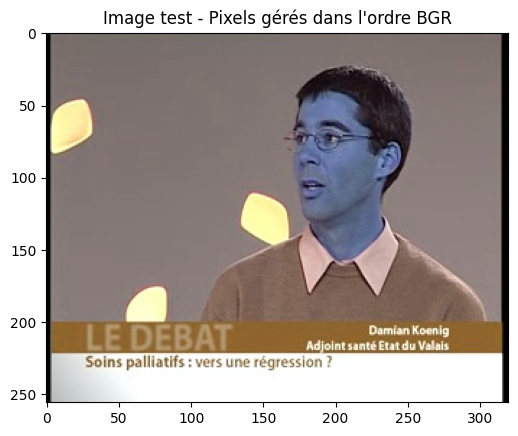

In [6]:
fig, ax = plt.subplots()
ax.set_title("Image test - Pixels gérés dans l'ordre BGR")
plt.imshow(img_test)
plt.show()

L'image ne s'affiche pas avec les bonnes couleurs. Nous remarquons qu'en effet, OpenCV ne gère pas les valeurs des pixels dans l'ordre RGB.  
Nous allons donc remettre les pixels dans l'ordre RGB :

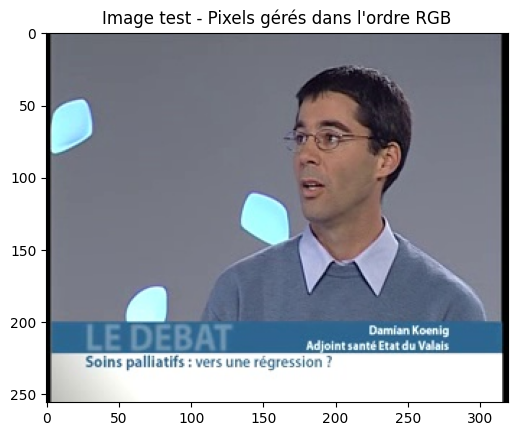

In [7]:
img_test_rgb = cv2.merge([r, g, b])
fig, ax = plt.subplots()
ax.set_title("Image test - Pixels gérés dans l'ordre RGB")
plt.imshow(img_test_rgb)
plt.show()

### Modification d'une image

Exercice 1 : Modifier le pixel de coordonnée (100,100) en le faisant devenir blanc

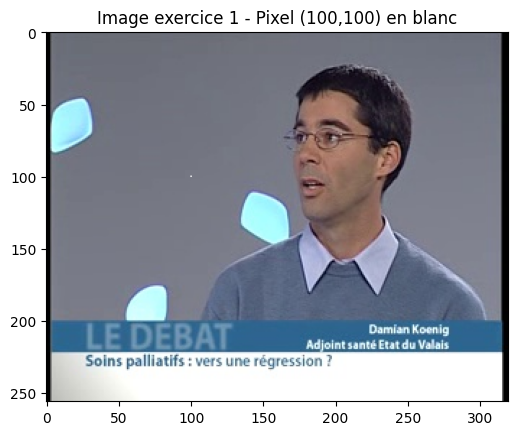

In [54]:
img_exo1=img_test_rgb
img_exo1[100,100]=(255,255,255)
fig, ax = plt.subplots()
ax.set_title("Image exercice 1 - Pixel (100,100) en blanc")
plt.imshow(img_exo1)
plt.show()

Exercice 2 : Faire apparaitre un carré bleu sur les 100x100 premiers pixels

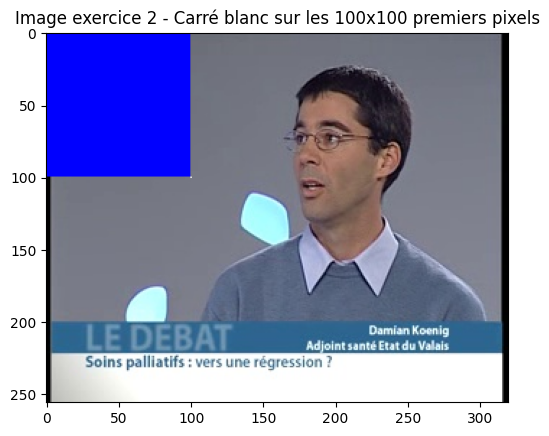

In [55]:
img_exo2=img_test_rgb
img_exo2[0:100,0:100]=(0,0,255)
fig, ax = plt.subplots()
ax.set_title("Image exercice 2 - Carré blanc sur les 100x100 premiers pixels")
plt.imshow(img_exo2)
plt.show()

Exercice 3 : Afficher uniquement le coin supérieur gauche de l'image

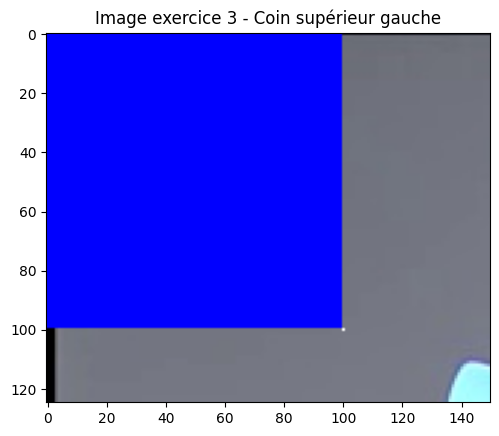

In [56]:
img_exo3=img_test_rgb
coin = img_exo3[0:125, 0:150]
fig, ax = plt.subplots()
ax.set_title("Image exercice 3 - Coin supérieur gauche")
plt.imshow(coin)
plt.show()

### Convertion de l'image en nuances de gris

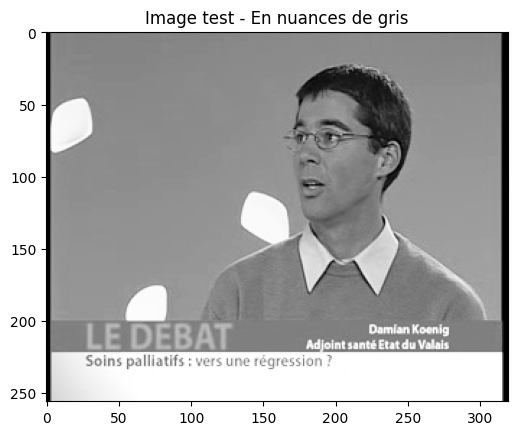

taille de l'image en nuance de gris : (256, 320)
Valeur minimale de l'intensité lumineuse : 0
Valeur maximale de l'intensité lumineuse : 255


In [57]:
img_test_grey = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots()
ax.set_title("Image test - En nuances de gris")
plt.imshow(img_test_grey, cmap = 'Greys_r')
plt.show()
print("taille de l'image en nuance de gris :", img_test_grey.shape)
print("Valeur minimale de l'intensité lumineuse :", np.min(img_test_grey))
print("Valeur maximale de l'intensité lumineuse :", np.max(img_test_grey))

La nouvelle matrice fait aussi 256 lignes par 320 colonnes, mais sur de simples octets. Cela permet de travailler en dimension moins grande. Dans le cas d’image noir et blanc il n’y a en effet qu’une valeur à stocker par pixel. L'intensité lumineuse prend toujours 256 valeurs. Lorsque l'intensité vaut 0, le pixel est noir, et lorsque l'intensité est de 255, le pixel est blanc. Toutes les valeurs intermédiaires sont des nuances de gris.

### Enregistrer une image

In [ ]:
# cv2.imwrite("images_tests\image_test_gris.jpg", grey_image)  # enregistre la matrice dans un fichier du nom indiqué

### Transformations - Thresholds et contours

Commençons tout de suite avec le thresholding (ou seuillage en français). Le seuillage est une binarisation de nos images. La plupart du temps nous allons binariser des images noirs et blancs.

 

Mais c’est quoi la binarisation ?

 

“En traitement d’image, la binarisation est une opération qui produit deux classes de pixels, en général, ils sont représentés par des pixels noirs et des pixels blancs.”

 

En gros, tous les pixels en dessous du seuil vont être converti en pixel noir, et ceux au dessus seront converti en pixel blanc.

Ainsi on pourra se concentrer sur la partie de l’image qui nous interesse.

 

Bien voyons maintenant les fonctions de thresholding d’OpenCV.

 

La première est cv2.threshold().

 

Elle demande quatre arguments: le premier est l’image à seuiller (forcément une image noir et blanc), le deuxième est le seuil, le troisième est la valeur maximum, et le dernier est la méthode de binarisation.

 

Principe de fonctionnement: Si la méthode de binarisation est cv2.THRESH_BINARY, alors chaque pixel ayant une intensité supérieure à celle du seuil verra sa valeur transformer en la valeur maximum (255 souvent). Les autres seront ramenés à une intensité de 0.

 

Si la méthode de binarisation est cv2.THRESH_BINARY_INV, alors ce sera l’inverse. Les pixels ayant une intensité supérieure au seuil seront ramenés à une intensité de 0, et les pixels ayant une intensité inférieure au seuil prendront la valeur de l’intensité maximale.

 

NB: la fonction cv2.threshold() retourne deux valeurs: la première est la valeur du seuil, et la deuxième est l’image seuillée.

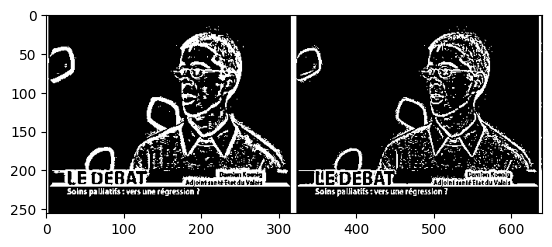

In [41]:
seuillagenorm = cv2.adaptiveThreshold(img_test_grey, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)
seuillagegaussien =  cv2.adaptiveThreshold(img_test_grey, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)

result = np.hstack([seuillagenorm, seuillagegaussien])

plt.imshow(result, cmap = 'Greys_r')
plt.show()

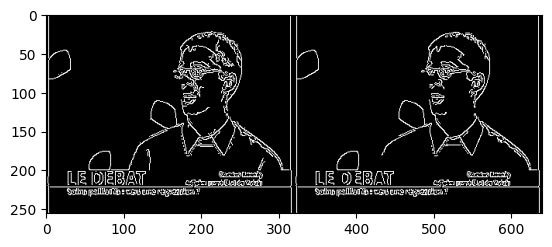

In [44]:
edge = cv2.Canny(img_test_grey, 30, 150)
edge1 = cv2.Canny(img_test_grey, 70, 200)

result = np.hstack([edge, edge1])
plt.imshow(result, cmap = 'Greys_r')
plt.show()

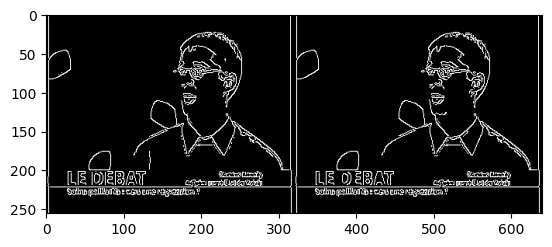

In [47]:
edge = imutils.auto_canny(img_test_grey)
edge1 = cv2.Canny(img_test_grey, 70, 200)

result = np.hstack([edge, edge1])
plt.imshow(result, cmap = 'Greys_r')
plt.show()

### Convertion de l'image dans l'espace colorimétrique HSV

Le modèle HSV est utilisé pour représenter les gammes de couleurs du modèle RVB sous une forme cylindrique. Cet espace colorimétrique est très utilisé pour le suivi d’objets.

Le modèle de couleur HSV signifie Hue, Saturation et Brightness (Value).

L’attribut Hue est utilisé pour spécifier la teinte de la couleur utilisée, et l’attribut Saturation détermine la quantité dans laquelle la couleur est utilisée. L’attribut Value permet de spécifier la luminosité de la couleur.  
Plage de la teinte (Hue) : [0,179]
Plage de la saturation : [0,255]
Plage de la valeur (Value) : [0,255]  

On se réfère à la teinte de l’objet  (le H) quand par exemple nous disons qu’il est rouge ou qu’il est vert.
La teinte est codée suivant l’angle qui lui correspond sur le cercle des couleurs. On a donc:
– 0° ou 360° : rouge ;   – 60° : jaune ;  -120° : vert ;  -180° : cyan ;  -240° : bleu ;  -300° : magenta.
Cependant comme nos valeurs ne peuvent pas dépasser 255, la teinte dans OpenCv est comprise entre 0 et 180 ( par exemple la teinte jaune vaut 30 dans OpenCV).

La saturation et la valeur elle seront comprises entre 0 et 255. Pour la valeur: 0 veut dire que le pixel est éteint et 255 qu’il est allumé au maximum . La saturation elle correspond à l’intensité de la couleur (0 veut dire gris et 255 veut dire “coloré au maximum”).

La saturation (Le S) représente la pureté de la couleur de l’objet, ainsi un objet rouge ayant une forte pureté un nous paraîtra éclatant, tandis qu’avec une faible pureté il aura plutôt un aspect délavé.

Pour finir, l’intensité (Le V) représente la quantité de lumière émise sur un objet, plus elle est forte et plus la couleur est claire, tandis que plus celle-ci est faible, plus la couleur de l’objet est sombre.

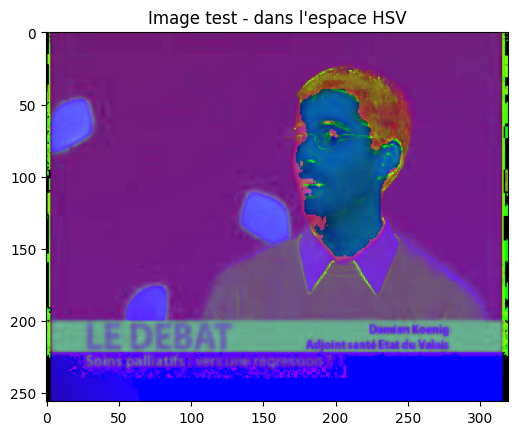

In [59]:
img_test_hsv = cv2.cvtColor(img_test, cv2.COLOR_BGR2HSV)
fig, ax = plt.subplots()
ax.set_title("Image test - dans l'espace HSV")
plt.imshow(img_test_hsv)
plt.show()

In [33]:
img_test_hsv.shape

(256, 320, 3)

L'image apparait bizarrement car l’afficheur ne sait pas que c’est une image HSV. Pour lui la première valeur de notre pixel sera l’intensité de la LED bleue alors qu’en fait cette valeur sera la teinte de notre pixel. Bien sûr le résultat visuel de la transformation HSV, n’est pas exploitable. Cependant cette transformation nous sera très utile par la suite.

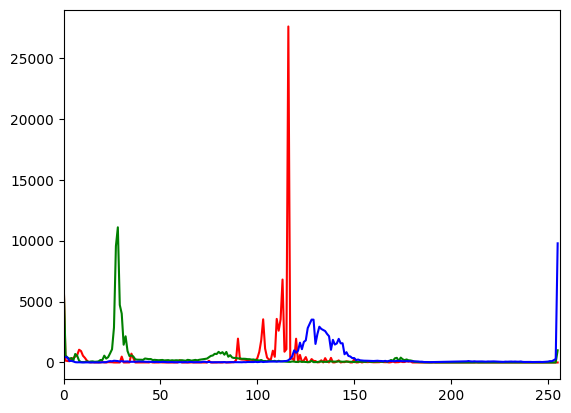

In [60]:
#Déclaration des couleurs des courbes
color = ('r','g','b')
#Déclaration des noms des courbes.
labels = ('h','s','v')
#Pour col allant r à b et pour i allant de 0 au nombre de couleurs
for i,col in enumerate(color):
    #Hist prend la valeur de l'histogramme de hsv sur la canal i.
    hist = cv2.calcHist([img_test_hsv],[i],None,[256],[0,256])
    # Plot de hist.
    plt.plot(hist,color = col,label=labels[i])
    plt.xlim([0,256])
#Affichage.
plt.show()